In [1]:
from unstructured.partition.auto import partition
from unstructured.partition.pdf import partition_pdf
from unstructured.partition.html import partition_html
from google import genai
from google.genai import types
import numpy as np
import chromadb
from dotenv import load_dotenv, dotenv_values

/home/mylee2662/Documents/education_walkthrough_lead/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Extraction from HTML

In [2]:
file_path = "examples/Exploring ColBERT with RAGatouille _ Simon Willison’s TILs.html"

elements = partition_html(file_path)


In [3]:
set([str(type(el)) for el in elements])

{"<class 'unstructured.documents.elements.Image'>",
 "<class 'unstructured.documents.elements.ListItem'>",
 "<class 'unstructured.documents.elements.NarrativeText'>",
 "<class 'unstructured.documents.elements.Text'>",
 "<class 'unstructured.documents.elements.Title'>"}

### Data Extraction from PDF

In [4]:
file_path = 'examples/2025_LCAP_CCS_LA-1.pdf'

elements = partition_pdf(
    filename=file_path, 
    strategy='hi_res',
    infer_table_structure=True,
    extract_image_block_types=["Image"],
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
    )

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [5]:
set([str(type(el)) for el in elements])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [6]:
# Each element is a chunk represented by a CompositeElement, which is used to store multiple elements of different types (Text, Image, Table, etc.)
for el in elements:
    print(type(el))
    print(el.to_dict())
    

<class 'unstructured.documents.elements.CompositeElement'>
{'type': 'CompositeElement', 'element_id': 'ac15e1418f7442de68b91dd33b93884f', 'text': 'COMPASS CHARTER SCHOOLS\n\nLCFF Budget Overview for Parents\n\nLocal Educational Agency (LEA) Name: Compass Charter Schools Los Angeles\n\nCDS Code: 10623310130880\n\nSchool Year: 2025-26\n\nLEA contact information:\n\nElizabeth Brenner\n\nSuperintendent, CEO\n\nebrenner@compasscharters.org\n\n(805)358-4761\n\nSchool districts receive funding from different sources: state funds under the Local Control Funding Formula (LCFF), other state funds, local funds, and federal funds. LCFF funds include a base level of funding for all LEAs and extra funding - called "supplemental and concentration" grants - to LEAs based on the enrollment of high needs students (foster youth, English learners, and low-income students).\n\nBudget Overview for the 2025-26 School Year\n\nProjected Revenue by Fund Source All federal funds, $517,601 , 3% Alllocal funds, $2

In [7]:
import pprint

pp = pprint.PrettyPrinter(indent=4)

for el in elements:
    pp.pprint(el.metadata.orig_elements)
    print("*" * 100)

[   <unstructured.documents.elements.Image object at 0x7e77e2141160>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7e77e25ca480>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7e77e25c8fe0>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7e77e35215e0>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7e77e2372030>,
****************************************************************************************************
[   <unstructured.documents.elements.Title object at 0x7e7788c56690>,
***************************************************************************

In [8]:
# Looking at the extracted tables

original_elements = []

for el in elements:
    original_elements += el.metadata.orig_elements
    
tables = [el for el in original_elements if 'Table' in str(type(el))]
tables_html = [el.metadata.text_as_html for el in original_elements if 'Table' in str(type(el))]

for i in range(len(tables)):
    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/tables/table_{i}.html", 'w')
    f.write(tables_html[i])
    f.close

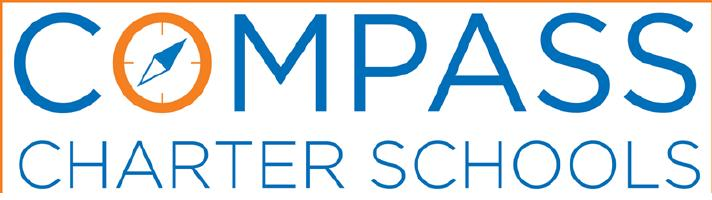

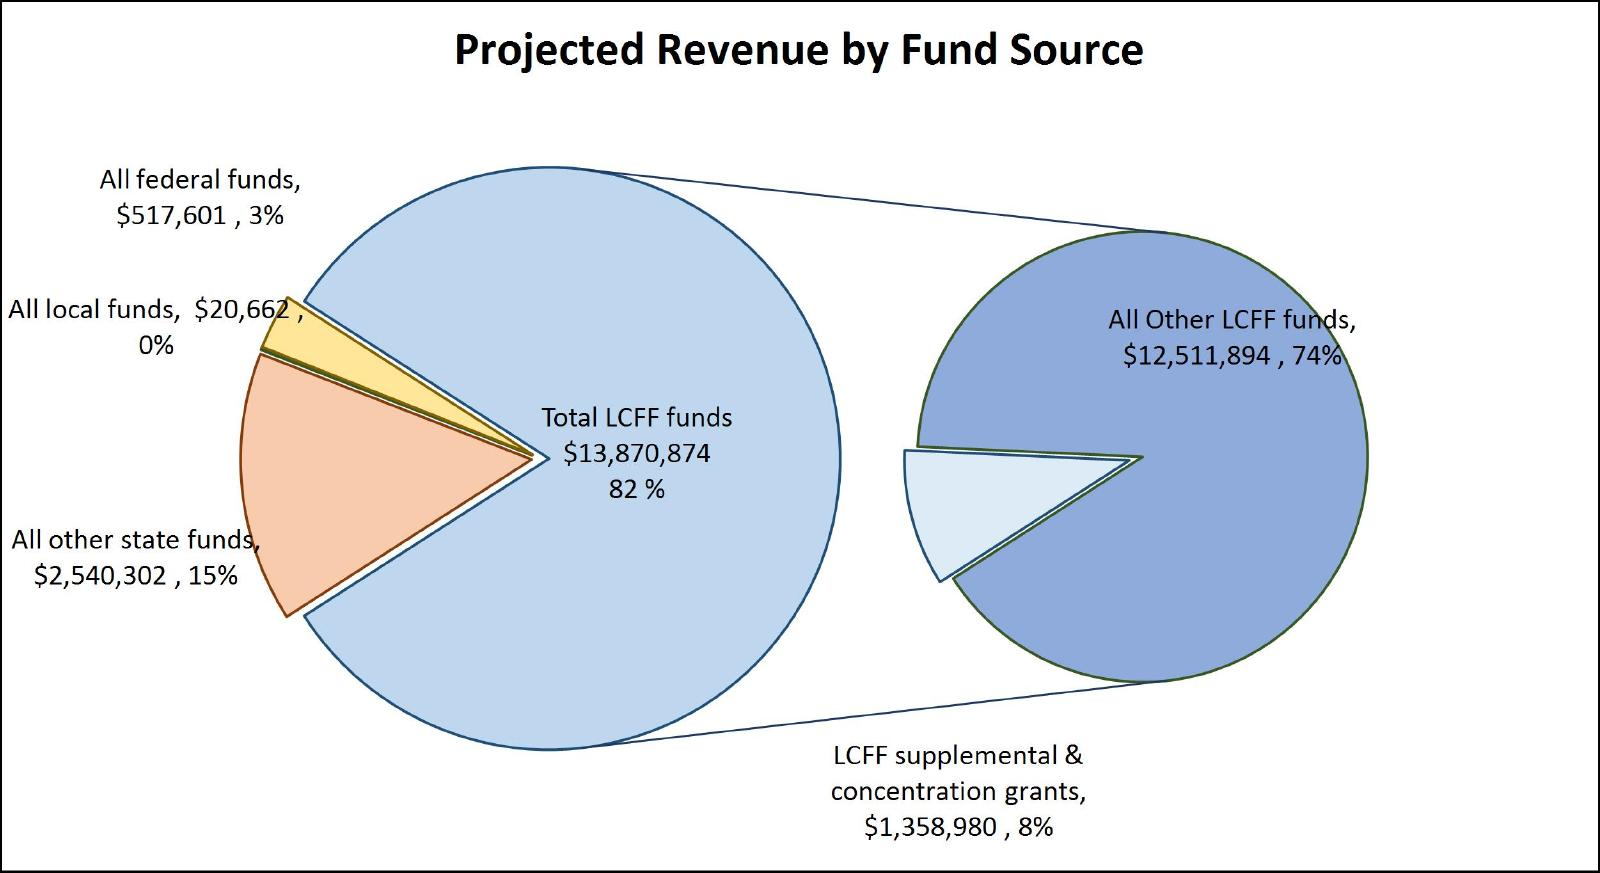

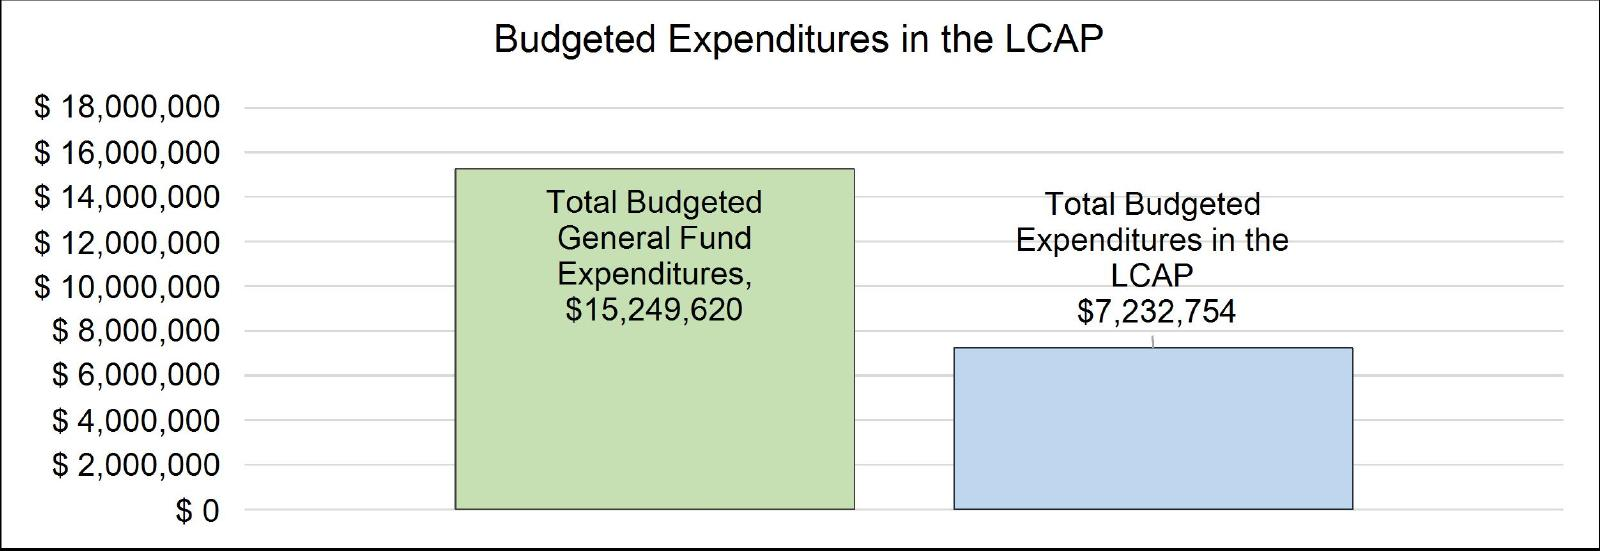

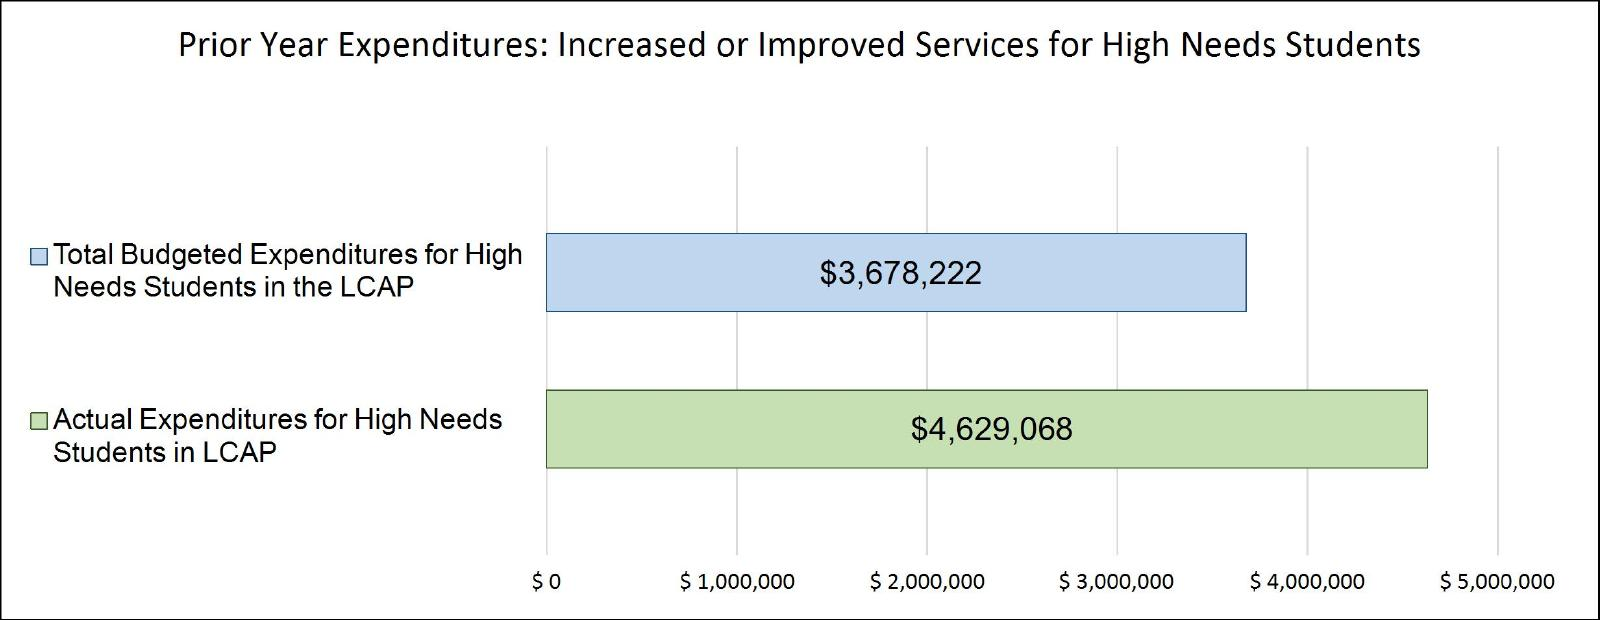

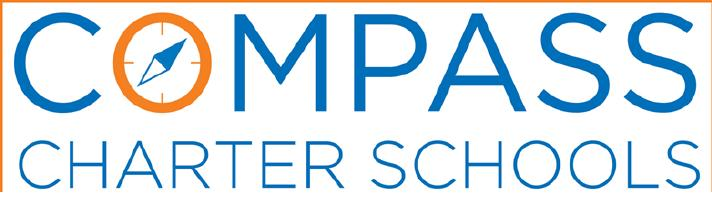

In [9]:
import base64
from IPython.display import Image, display

def display_image(image_base64):
    img_data = base64.b64decode(image_base64)
    display(Image(data=img_data))

    f = open(f"/home/mylee2662/Documents/education_walkthrough_lead/images/image_{i}.webp", 'wb')
    f.write(img_data)
    f.close

images = [el.metadata.image_base64 for el in original_elements if 'Image' in str(type(el))]

for i in range(len(images)):
    display_image(images[i])

In [10]:
texts = [el for el in elements if 'CompositeElement' in str(type(el))]

for text in texts:
    print(text)
    print('*' * 100)

COMPASS CHARTER SCHOOLS

LCFF Budget Overview for Parents

Local Educational Agency (LEA) Name: Compass Charter Schools Los Angeles

CDS Code: 10623310130880

School Year: 2025-26

LEA contact information:

Elizabeth Brenner

Superintendent, CEO

ebrenner@compasscharters.org

(805)358-4761

School districts receive funding from different sources: state funds under the Local Control Funding Formula (LCFF), other state funds, local funds, and federal funds. LCFF funds include a base level of funding for all LEAs and extra funding - called "supplemental and concentration" grants - to LEAs based on the enrollment of high needs students (foster youth, English learners, and low-income students).

Budget Overview for the 2025-26 School Year

Projected Revenue by Fund Source All federal funds, $517,601 , 3% Alllocal funds, $20,66; 0% Total LCFF funds $13,870,874 82% All other state fund $2,540,302 , 15% LCFF supplemental & concentration grants, $1,358,980 , 8%

This chart shows the total gener

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

load_dotenv()

summarization_model = ChatOpenAI(model="gpt-4o")

text_table_summarization_prompt = ChatPromptTemplate.from_template(
    """
    You are an assistant tasked with summarizing tables and text.
    Give a concise summary of the table or text.

    Respond only with the summary, no additional comment.
    Do not start your message by saying "Here is a summary" or anything like that.
    Just give the summary as it is.

    Table or text chunk: {element}
    """
)

text_table_summarize_chain = {"element": lambda x: x} | text_table_summarization_prompt | summarization_model | StrOutputParser()

img_summarization_prompt_text = """Describe the image in detail. For context,
                  the image is part of a school district's improvement plan document.
                  Be specific about graphs and text content.
                  Respond only with the description of the image, no additional comment.
                  """

img_summarization_messages = [
    (
        "user",
        [
            {
                "type": "text",
                "text": img_summarization_prompt_text
            },
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"}
            }
        ]
    )
]

img_summarization_prompt = ChatPromptTemplate.from_messages(img_summarization_messages)

img_summarize_chain = img_summarization_prompt | summarization_model | StrOutputParser()

In [12]:
text_summaries = text_table_summarize_chain.batch(texts)
pp.pprint(text_summaries)

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-zX53cnZOtjJI8wyuHR2aXWki on tokens per min (TPM): Limit 30000, Used 30000, Requested 1038. Please try again in 2.076s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [ ]:
table_summaries = text_table_summarize_chain.batch(tables)
pp.pprint(table_summaries)

[   'The table outlines goals and objectives focused on academic growth and '
    'emotional well-being for students, with a vision of thriving and '
    'engagement. The goals cover areas such as Math and ELA achievement, '
    'social/emotional development, and effective teacher pedagogy. Various '
    'indicators and survey questions assess progress in writing expression, '
    'language conventions, and involvement. Notable targets include a 64% goal '
    'in writing claim objectives and high percentages in forthcoming and '
    'emotional/social indicators, with specifics like the 3x3 Writing Teaching '
    'Framework and strategies for school-based communication and grammar '
    'practices.',
    "Students' academic achievement goals in CCRS Literacy and Math denote "
    'mixed results. The literacy writing claim has an average scaled score '
    'that increased slightly to 36 in SY 22/23 but remains below the desired '
    'score of 50. There are no sustained trends in scores

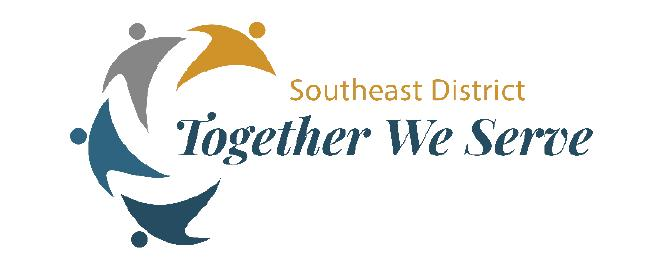

The image features a logo that includes stylized figures in a circular arrangement, symbolizing unity or collaboration. The figures are in different colors: gray, orange, and blue. To the right of these figures, there is text that reads "Southeast District" in orange and "Together We Serve" in blue. The font style is professional and easy to read, with an emphasis on the phrase "Together We Serve." The overall design conveys a sense of community and collaborative effort.


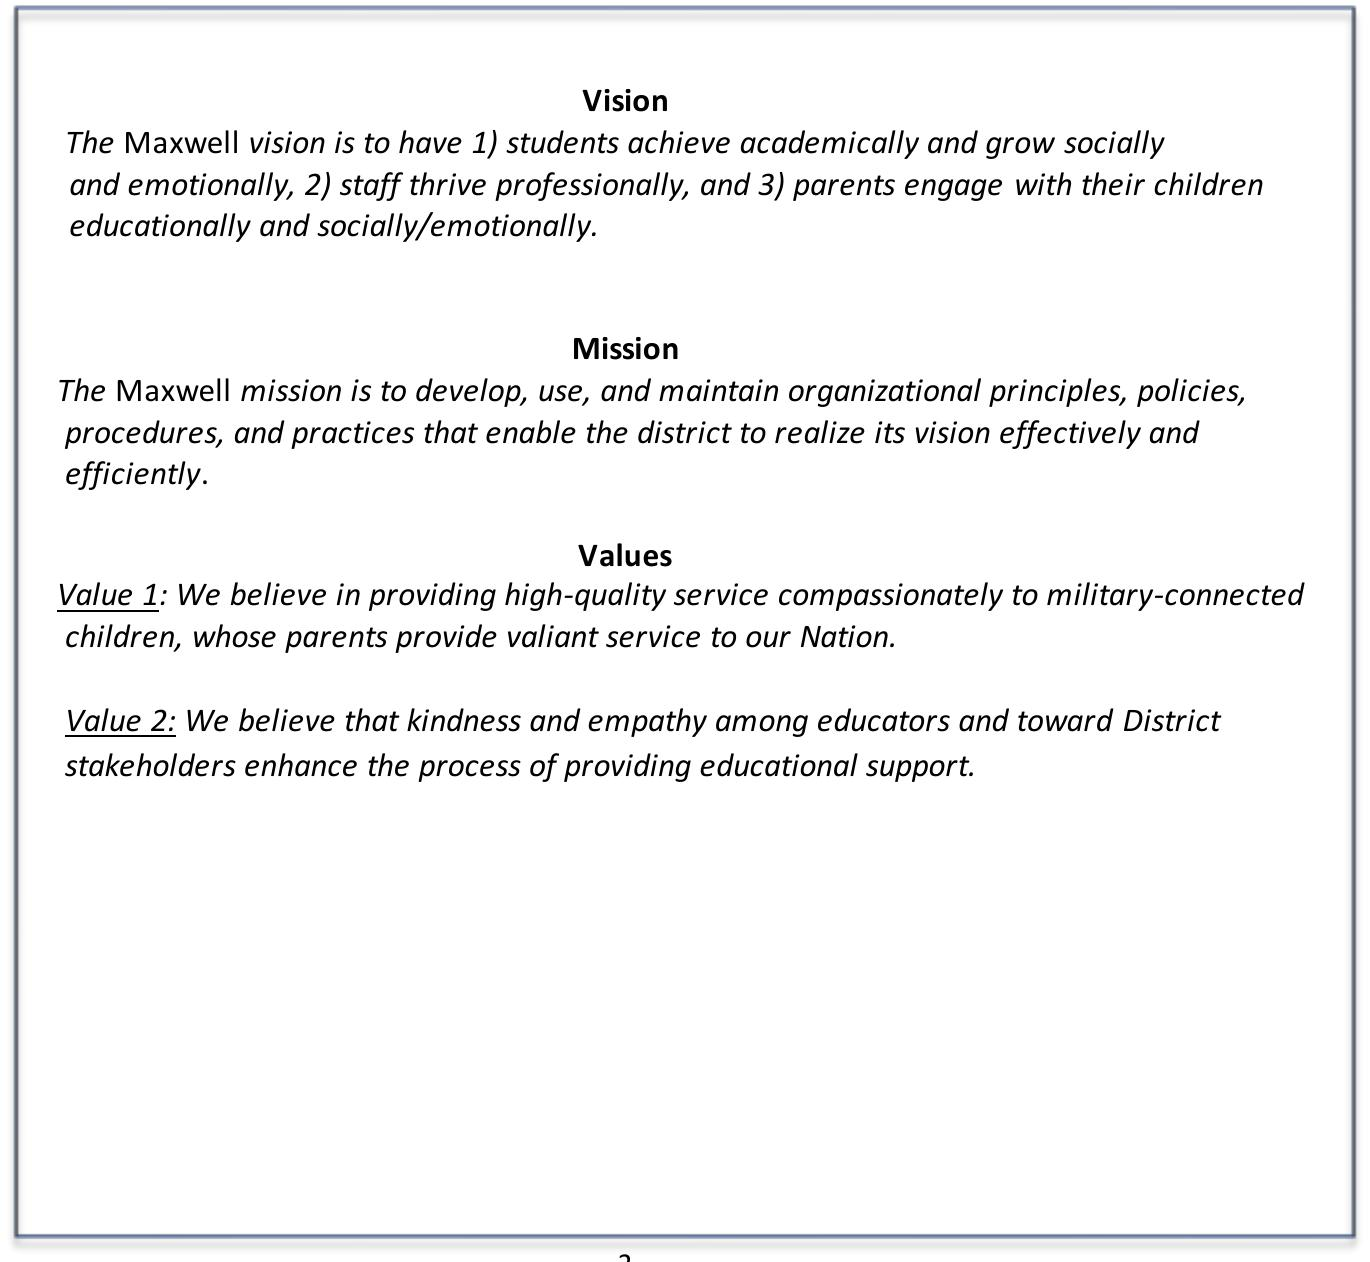

The image contains a section of a school district's improvement plan document with the following text content divided into three parts:

**Vision**  
The Maxwell vision is to have 1) students achieve academically and grow socially and emotionally, 2) staff thrive professionally, and 3) parents engage with their children educationally and socially/emotionally.

**Mission**  
The Maxwell mission is to develop, use, and maintain organizational principles, policies, procedures, and practices that enable the district to realize its vision effectively and efficiently.

**Values**  

- **Value 1:** We believe in providing high-quality service compassionately to military-connected children, whose parents provide valiant service to our Nation.

- **Value 2:** We believe that kindness and empathy among educators and toward District stakeholders enhance the process of providing educational support.


In [ ]:
image_summaries = img_summarize_chain.batch(images)
for i in range(len(images)):
    img_data = base64.b64decode(images[i])
    display(Image(data=img_data))
    print(image_summaries[i])

# pp.pprint(image_summaries)

### Embed Data

In [ ]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings())

store = InMemoryStore()
id_key = "doc_id"

retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
    search_kwargs={"k": 5}
)

text_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [Document(page_content=text, metadata={id_key: text_ids[i]}) for i, text in enumerate(text_summaries)]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(text_ids, texts)))

table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [Document(page_content=table, metadata={id_key: table_ids[i]}) for i, table in enumerate(table_summaries)]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

image_ids = [str(uuid.uuid4()) for _ in images]
summary_images = [Document(page_content=img, metadata={id_key: image_ids[i]}) for i, img in enumerate(image_summaries)]
retriever.vectorstore.add_documents(summary_images)
retriever.docstore.mset(list(zip(image_ids, images)))

In [ ]:
docs = retriever.invoke("What is the Maxwell vision?")

for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATuBVoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+oLu7isrdp522xr1NT1zfjh8eF7kZ9Ka3Bi/8Jvox6SSn6JS/wDCbaN/fm/791zXgzSNOu/DkUs8RaQu2Tu966D/AIR/SP8An3P/AH0av935k+8S/wDCbaN/fm/790f8Jto/9+b/AL91F/wj+kf8+5/76NH/AAj+k/8APA/9

In [ ]:
multi_query_prompt_template = """You are an AI language model assistant. Your task is to generate five 
different versions of the given user question to retrieve relevant documents from a vector 
database. By generating multiple perspectives on the user question, your goal is to help
the user overcome some of the limitations of the distance-based similarity search. 
Provide these alternative questions separated by newlines. Original question: {question}"""

multi_query_prompt = ChatPromptTemplate.from_template(multi_query_prompt_template)

generate_queries = (
    multi_query_prompt 
    | ChatOpenAI(temperature=0) 
    | StrOutputParser() 
    | (lambda x: x.split("\n"))
)


In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain.load import dumps, loads

def get_unique_docs(docs_lst):
    unique_docs = []

    for docs in docs_lst:
        for doc in docs:
            if(doc not in unique_docs):
                unique_docs.append(doc)

    return unique_docs

def parse_docs(docs):
    retrieved_images, retrieved_texts = [], []

    print(type(docs))
    print(type(docs[0]))

    for doc in docs:
        # pp.pprint(doc)
        try:
            base64.b64decode(doc)
            retrieved_images.append(doc)
        except Exception as e:
            retrieved_texts.append(doc)

    return {
        "images": retrieved_images,
        "texts": retrieved_texts
    }

def build_prompt(kwargs):
    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    for retrieved_text in docs_by_type["texts"]:
        context_text += retrieved_text.text

    prompt_text = f"""
        Answer the question based only on the following context, which can include text, tables, and the below image.
        Context: {context_text}
        Question: {user_question}
    """

    prompt_content = [{
        "type": "text",
        "text": prompt_text
    }]

    if(len(docs_by_type["images"]) > 0):
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"}
                }
            )

    return ChatPromptTemplate(
        [
            HumanMessage(content=prompt_content)
        ]
    )

In [ ]:
queries = generate_queries.invoke({"question": "What is the Maxwell vision?"})
print(queries)

['1. Can you explain the concept of Maxwell vision?', '2. How would you define the Maxwell vision?', '3. What are the key components of the Maxwell vision?', '4. Could you provide insights into the Maxwell vision?', '5. In what ways is the Maxwell vision described or understood?']


In [ ]:
multi_query_retrieval_chain = generate_queries | retriever.map() | RunnableLambda(get_unique_docs) | RunnableLambda(parse_docs)
docs = multi_query_retrieval_chain.invoke({"question": "What is the Maxwell vision?"})
# print(len(docs["texts"]))
print(type(docs))
print(docs)

print(len(docs["texts"]))

# multi_query_retrieval_chain = retriever | RunnableLambda(parse_docs)
# docs = multi_query_retrieval_chain.invoke("What is the Maxwell vision?")

<class 'list'>
<class 'str'>
<class 'dict'>
{'images': ['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCATuBVoDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3+oLu7isrdp522xr1NT1zfjh8eF7kZ9Ka3Bi/8Jvox6SSn6JS/wDCbaN/fm/791zXgzSNOu/DkUs8RaQu2Tu966D/AIR/SP8An3P/AH0av935k+8

In [ ]:
chain_with_sources = {
    "context": generate_queries | retriever.map() | RunnableLambda(get_unique_docs) | RunnableLambda(parse_docs),
    "question": RunnablePassthrough()
} | RunnablePassthrough().assign(
    response = (
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o")
        | StrOutputParser()
    )
)

chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

In [ ]:
response = chain_with_sources.invoke("What are the staff goals? and objectives?")

pp.pprint(response['context'])
print(response['response'])

<class 'list'>
<class 'unstructured.documents.elements.CompositeElement'>
{   'images': [],
    'texts': [   <unstructured.documents.elements.CompositeElement object at 0x77d2fde59bb0>,
                 <unstructured.documents.elements.CompositeElement object at 0x77d2fde5a7b0>]}
The staff goals and objectives are as follows:

1. **Staff Goals:**
   - **2.1.1**: Teachers will have strong pedagogical skills, knowledge, and ability.
   - **2.1.2**: Staff will have high emotional well-being and be socially connected to other district stakeholders.

2. **Objectives:**
   - **2.1 (Pedagogical Skills)**:
     - Goal is to achieve a school-wide score of at least 75% for indicator 12 for each year from SY23/24 to SY25/26.
   - **2.2 (Emotional Well-being and Social Connection)**:
     - Achieve a school-wide percent observed score of at least 80% for indicator 5.d and 70% for indicator 5.e for each year from SY23/24 to SY25/26.
     - Achieve a school-wide score of at least 60% for the Faculty

In [ ]:
context = response['context']
for text in context['texts']:
    print(text)
    print('*' * 100)

Staff Section

Table 16 contains the information on the staff goals. It prepopulated with the core information, so you should not need to change any content in the first four columns. There is exemplar language for the rationale and objective sections. You can retain the language and just insert your school’s supporting and objective scores.

Tables 17, 18 and 20 are for your LWT, FCOT and C/E staff data, so you will need to enter these scores and then compute the average and standard deviation. If you need help doing so, contact Miles Cooper.

Tables 21 and 22 contain the required staff strategies and action plans; you do not need to change what is in here.

Table 24 is where you will place your strategy for the staff social/emotional goal. Although the goal, which is “involved staff,” is mandated, schools will have to choose and develop a strategy on how to achieve the goal.

Parent Section

Table 25 contains the information on the parent goals. It’s prepopulated with the core inform

In [ ]:
from pydantic import BaseModel, Field

class ResponseSchema(BaseModel):
    answer: str = Field(description="The answer to the user's question based on the provided context.")
    is_affirmative: bool = Field(description="Indicates whether the answer is affirmative or not.")
    sources: list[str] = Field(description="A list of sources used to generate the answer.")

In [ ]:
structured_llm = ChatOpenAI(model="gpt-4o").with_structured_output(ResponseSchema)

structured_chain_with_sources = {
    "context": generate_queries | retriever.map() | RunnableLambda(get_unique_docs) | RunnableLambda(parse_docs),
    "question": RunnablePassthrough()
} | RunnablePassthrough().assign(
    response = (
        RunnableLambda(build_prompt)
        | structured_llm
    )
)

structured_chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | structured_llm
)

In [ ]:
response = structured_chain_with_sources.invoke("Are there mentions of professional development?")
pp.pprint(response)

context = response['context']
for text in context['texts']:
    print(text)
    print('*' * 100)


<class 'list'>
<class 'unstructured.documents.elements.Table'>
{   'context': {   'images': [],
                   'texts': [   <unstructured.documents.elements.Table object at 0x77d2f8c00710>,
                                <unstructured.documents.elements.Table object at 0x77d2c85566f0>]},
    'question': 'Are there mentions of professional development?',
    'response': ResponseSchema(answer='Yes, the document mentions professional development. It refers to "PL" which is likely an abbreviation for "Professional Learning" or "Professional Development." Specifically, the context states: \n\n1. "Grammar Document to record when and where support was provided PL delivery."\n2. "Number of PLs delivered Dec., June."\n3. "Plan Number PL support session delivered Quarterly."\n\nAdditionally, it refers to supporting teachers through specific strategies like FC Targeted Support and LWT Targeted Support, which involve on-going support and would be part of professional development efforts.', is

In [ ]:
response = structured_chain_with_sources.invoke("Are there mentions of being International Baccalaureate (IB) certified or seeking IB certification?")
pp.pprint(response)

context = response['context']
for text in context['texts']:
    print(text)
    print('*' * 100)


<class 'list'>
<class 'unstructured.documents.elements.Table'>
{   'context': {   'images': [],
                   'texts': [   <unstructured.documents.elements.Table object at 0x77d2c85566f0>,
                                <unstructured.documents.elements.Table object at 0x77d2c8555130>]},
    'question': 'Are there mentions of being International Baccalaureate (IB) '
                'certified or seeking IB certification?',
    'response': ResponseSchema(answer='No, there is no mention in the context provided about being International Baccalaureate (IB) certified or seeking IB certification.', is_affirmative=False, sources=[])}
Strategy Description FC Targeted Support. School administrators and ISSs will provide on-going, targeted support to teachers on the processes used within their FC meeting to differentiate students into groups and select appropriate interventions. The support mode and content will be developed and delivered based on an evaluation of FC Teams’ need, using data

In [ ]:
response = structured_chain_with_sources.invoke("Are there mentions of being Advanced Placement (AP) certified or seeking AP certification?")
pp.pprint(response)

context = response['context']
for text in context['texts']:
    print(text)
    print('*' * 100)


<class 'list'>
<class 'unstructured.documents.elements.Table'>
{   'context': {   'images': [],
                   'texts': [   <unstructured.documents.elements.Table object at 0x77d2c8566e10>,
                                <unstructured.documents.elements.Table object at 0x77d2c8566c30>]},
    'question': 'Are there mentions of being Advanced Placement (AP) certified '
                'or seeking AP certification?',
    'response': ResponseSchema(answer='The provided context does not mention any information related to being Advanced Placement (AP) certified or seeking AP certification. The data focuses on various measures of proficiency, staff and student goals, and strategies for improvement within K-8 education and does not reference AP courses or certifications.', is_affirmative=False, sources=[])}
Data Source Frequency/Unit Domain Tested Grades Measure Benchmark Advance 2, 5, 7 Writing Portion 3-5 Percent proficient 80% Benchmark Performance 2, 5, 8 Writing Portion 3-5 Percent P

In [ ]:
response = structured_chain_with_sources.invoke("Are there mentions of being Advancement Via Individual Determination (AVID) certified or seeking AVID certification?")
pp.pprint(response)

context = response['context']
for text in context['texts']:
    print(text)
    print('*' * 100)


<class 'list'>
<class 'unstructured.documents.elements.Table'>
{   'context': {   'images': [],
                   'texts': [   <unstructured.documents.elements.Table object at 0x77d2c8555130>,
                                <unstructured.documents.elements.Table object at 0x77d2c856e6f0>]},
    'question': 'Are there mentions of being Advancement Via Individual '
                'Determination (AVID) certified or seeking AVID certification?',
    'response': ResponseSchema(answer='The context provided does not mention being Advancement Via Individual Determination (AVID) certified or seeking AVID certification. There is no reference to the AVID program or any certification associated with it. The context mainly discusses supporting scores, outcome scores, pedagogical strategies, goals, and strategies for improving staff and student outcomes.\n\nIf you need more specific information, kindly provide further context or a more focused area of inquiry.', is_affirmative=False, sources=[])}